In [102]:
# Import libraries
import math

import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.stats import zscore
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist  #Pairwise distribution between data points

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer

In [103]:
# Adjust display and formatting settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [30, 15]
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 500)           
pd.set_option('display.max_rows', 500) 

In [104]:
# Read the data
credit = pd.read_excel("Credit Card Customer Data.xlsx")

<br/>

# 1. Univariate Analysis

In [105]:
credit.head()

Sl_No  Customer Key  Avg_Credit_Limit  Total_Credit_Cards  \
0      1         87073            100000                   2   
1      2         38414             50000                   3   
2      3         17341             50000                   7   
3      4         40496             30000                   5   
4      5         47437            100000                   6   

   Total_visits_bank  Total_visits_online  Total_calls_made  
0                  1                    1                 0  
1                  0                   10                 9  
2                  1                    3                 4  
3                  1                    1                 4  
4                  0                   12                 3

In [106]:
# All data of type int64
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [107]:
# No missing values
credit.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [108]:
credit.describe().T

count      mean       std       min       25%       50%  \
Sl_No               660.00    330.50    190.67      1.00    165.75    330.50   
Customer Key        660.00 55,141.44 25,627.77 11,265.00 33,825.25 53,874.50   
Avg_Credit_Limit    660.00 34,574.24 37,625.49  3,000.00 10,000.00 18,000.00   
Total_Credit_Cards  660.00      4.71      2.17      1.00      3.00      5.00   
Total_visits_bank   660.00      2.40      1.63      0.00      1.00      2.00   
Total_visits_online 660.00      2.61      2.94      0.00      1.00      2.00   
Total_calls_made    660.00      3.58      2.87      0.00      1.00      3.00   

                          75%        max  
Sl_No                  495.25     660.00  
Customer Key        77,202.50  99,843.00  
Avg_Credit_Limit    48,000.00 200,000.00  
Total_Credit_Cards       6.00      10.00  
Total_visits_bank        4.00       5.00  
Total_visits_online      4.00      15.00  
Total_calls_made         5.00      10.00

In [109]:
pandas_profiling.ProfileReport(credit)

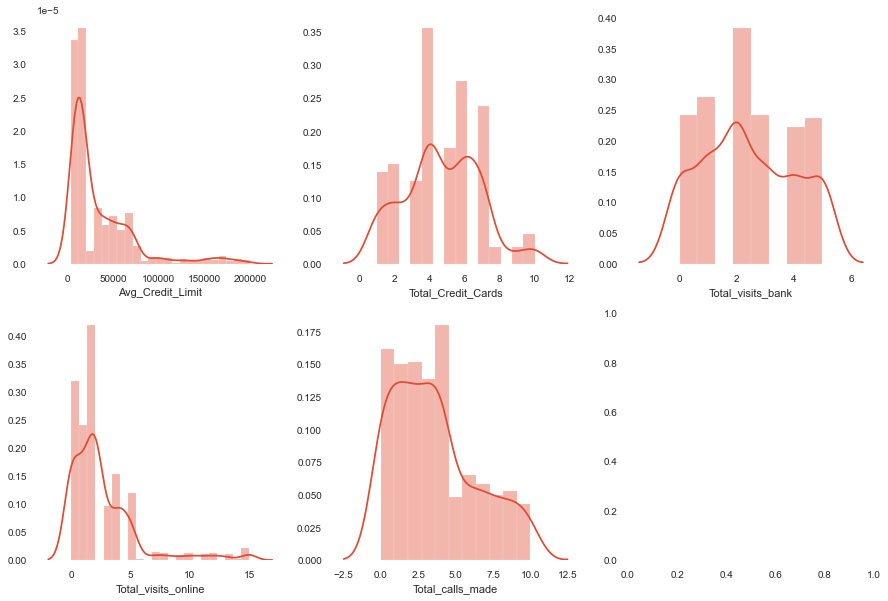

In [23]:
# Analyze distribution of data using histograms
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(15,10))

colIndex = 0 
features = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']
for col in features:
    sns.distplot(credit[col], ax = axs[math.floor(colIndex/3)][colIndex % 3]);
    colIndex += 1

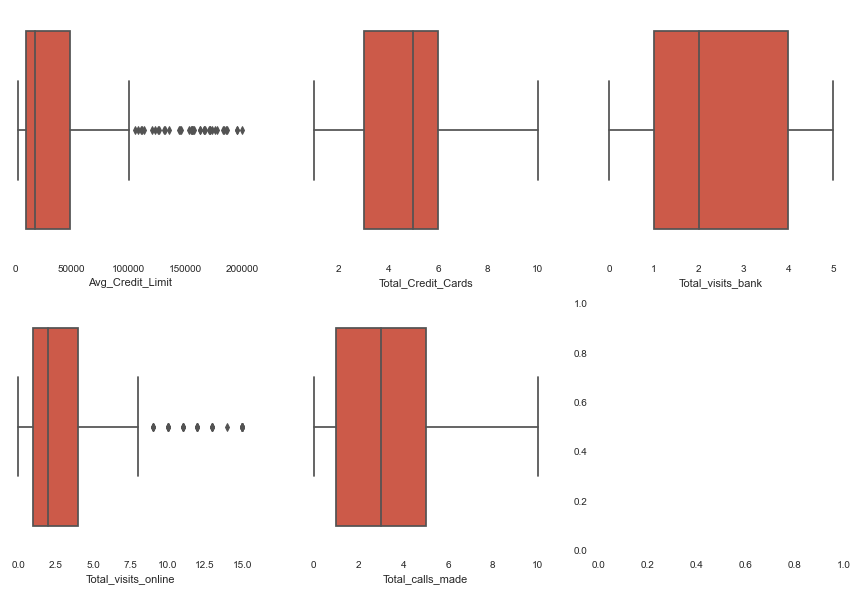

In [18]:
# Outlier detection with Box plots
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(15,10))

colIndex = 0 
for col in features:
    sns.boxplot(credit[col], ax = axs[math.floor(colIndex/3)][colIndex % 3]);
    colIndex += 1

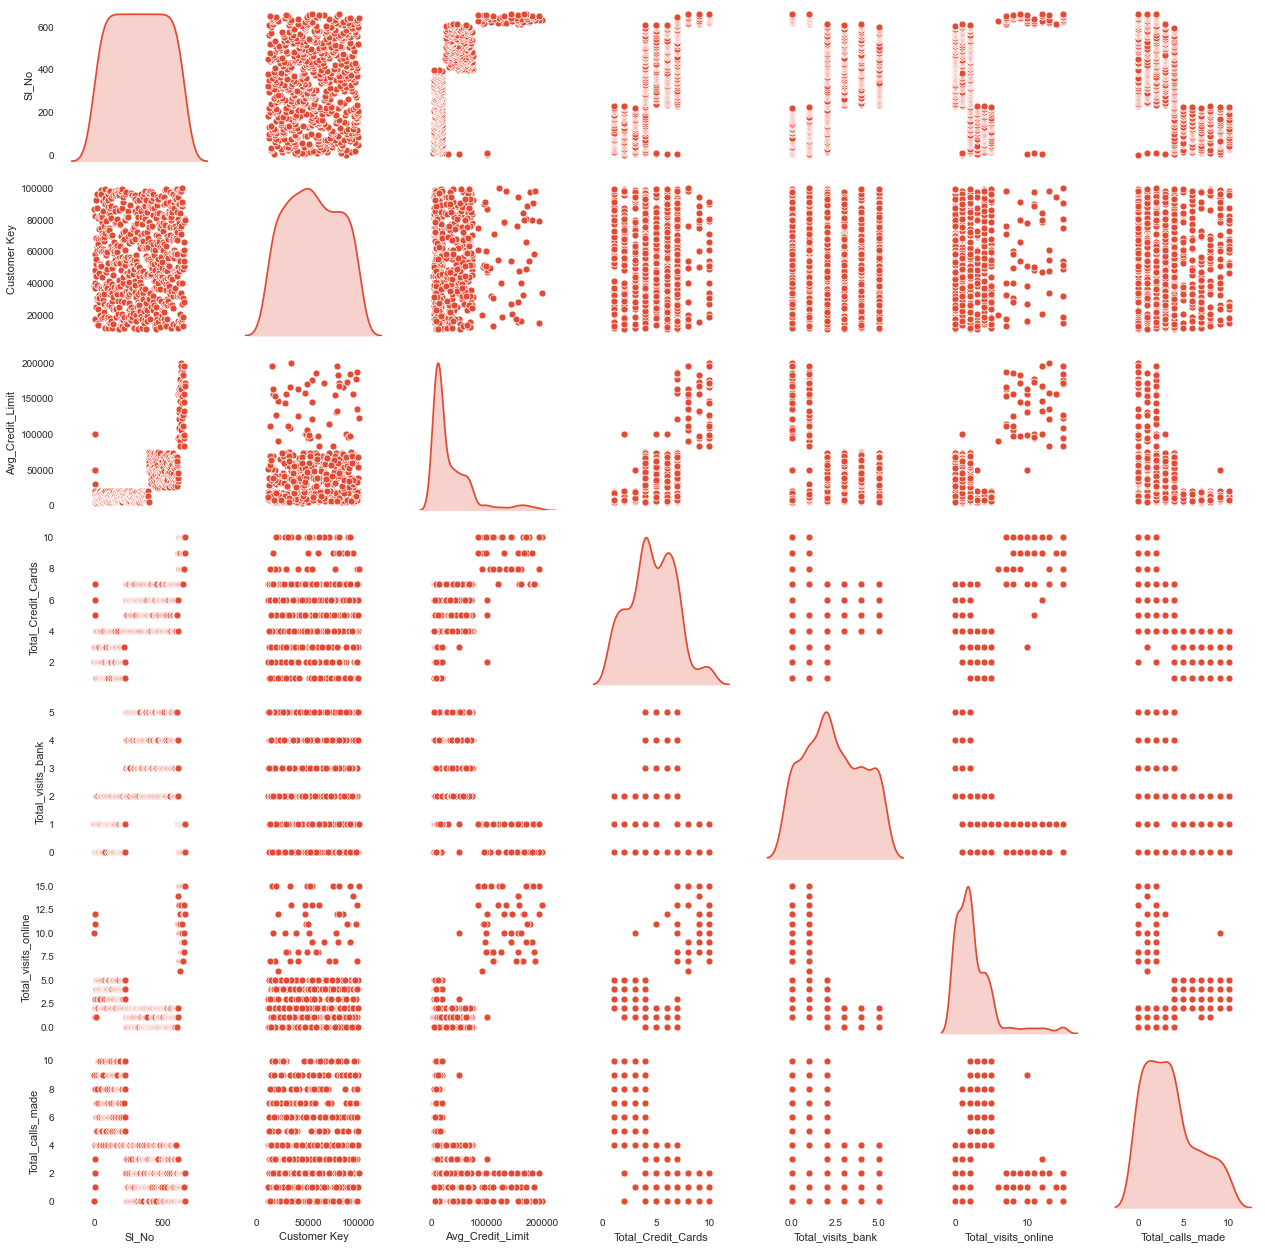

In [19]:
# Pair plot with kernel density graph on the 
# diagonals to see the distribution
sns.pairplot(credit, diag_kind='kde')

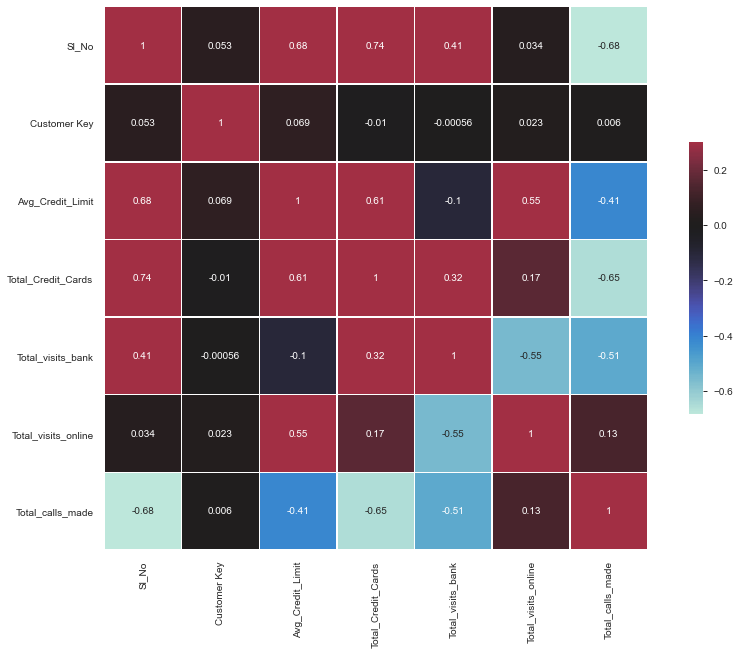

In [21]:
# Plot heatmap to visualize the correlation between the features
plt.figure(figsize = (15,10))
corr = credit.corr()
sns.heatmap(corr, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

<br/>

# 2. Insights
<br/>

### Missing values and outliers
* There are no missing data
* Average_credit_limit and Total_visits_online are highly right skewed(have outliers)

<br/>

### Data distribution
* Average_credit_limit has a multi-modal distribution signifying atleast 4 clusters
* Total_credit_cards also has a multi-modal distribution signifying atleast 4 clusters
* Total_visits_bank also has a multi-modal distribution signifying atleast 3 clusters
* Total_visits_online also has a multi-modal distribution signifying atleast 3 clusters
* Total_calls_made also has a multi-modal distribution signifying atleast 2 clusters

<br/>

### Correlation based analysis
* People with higher number of credit cards:
> * have higher average credit limit <br/>
> * make less calls to the bank <br/>
* People with higher average credit:
> * make less calls to the bank <br/>
> * make more online visits <br/>

<br/>

# 3. K-means clustering

In [53]:
# Drop Sl_No and Customer_key as they are just unique id's
# Scale the data
credit_z = credit.drop(['Sl_No', 'Customer Key'], axis = 1).apply(zscore)
credit_z.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              1.74               -1.25              -0.86   
1              0.41               -0.79              -1.47   
2              0.41                1.06              -0.86   
3             -0.12                0.14              -0.86   
4              1.74                0.60              -1.47   

   Total_visits_online  Total_calls_made  
0                -0.55             -1.25  
1                 2.52              1.89  
2                 0.13              0.15  
3                -0.55              0.15  
4                 3.20             -0.20

In [24]:
credit_z.describe().T

count  mean  std   min   25%   50%  75%  max
Avg_Credit_Limit    660.00  0.00 1.00 -0.84 -0.65 -0.44 0.36 4.40
Total_Credit_Cards  660.00 -0.00 1.00 -1.71 -0.79  0.14 0.60 2.44
Total_visits_bank   660.00  0.00 1.00 -1.47 -0.86 -0.25 0.98 1.59
Total_visits_online 660.00  0.00 1.00 -0.89 -0.55 -0.21 0.48 4.22
Total_calls_made    660.00 -0.00 1.00 -1.25 -0.90 -0.20 0.49 2.24

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

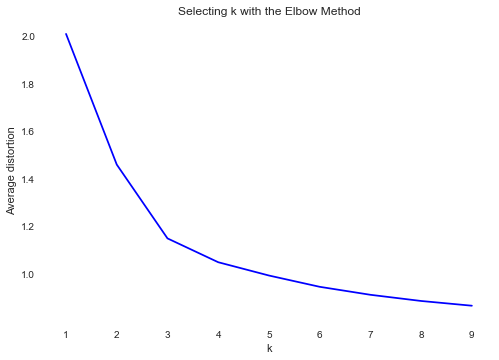

In [36]:
# Try K-Means clustering with values of k from 1 to 9
# Draw elbow plot
clusters=range(1,10)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(credit_z)
    prediction=model.predict(credit_z)
    meanDistortions.append(sum(np.min(cdist(credit_z, model.cluster_centers_, 'euclidean'), axis=1)) / credit_z
                           .shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

In [83]:
# From the elbow plot, cluster size of 3 seems to be the optimum
# Run K-Means with value of k as 3
kmeans = KMeans(n_clusters=3, n_init = 15, random_state=123)
prediction_kmeans = kmeans.fit_predict(credit_z)

In [86]:
## create a new dataframe only for labels and converting it into categorical variable
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['label']))
df_labels['label'] = df_labels['label'].astype('category')

In [95]:
# Join the label dataframe with the data frame.
creditz_clusters_kmeans = credit_z.join(df_labels)
creditz_clusters_kmeans.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              1.74               -1.25              -0.86   
1              0.41               -0.79              -1.47   
2              0.41                1.06              -0.86   
3             -0.12                0.14              -0.86   
4              1.74                0.60              -1.47   

   Total_visits_online  Total_calls_made label  
0                -0.55             -1.25     0  
1                 2.52              1.89     2  
2                 0.13              0.15     0  
3                -0.55              0.15     0  
4                 3.20             -0.20     1

/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/kumaras

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b9c5ad0>,
      dtype=object)

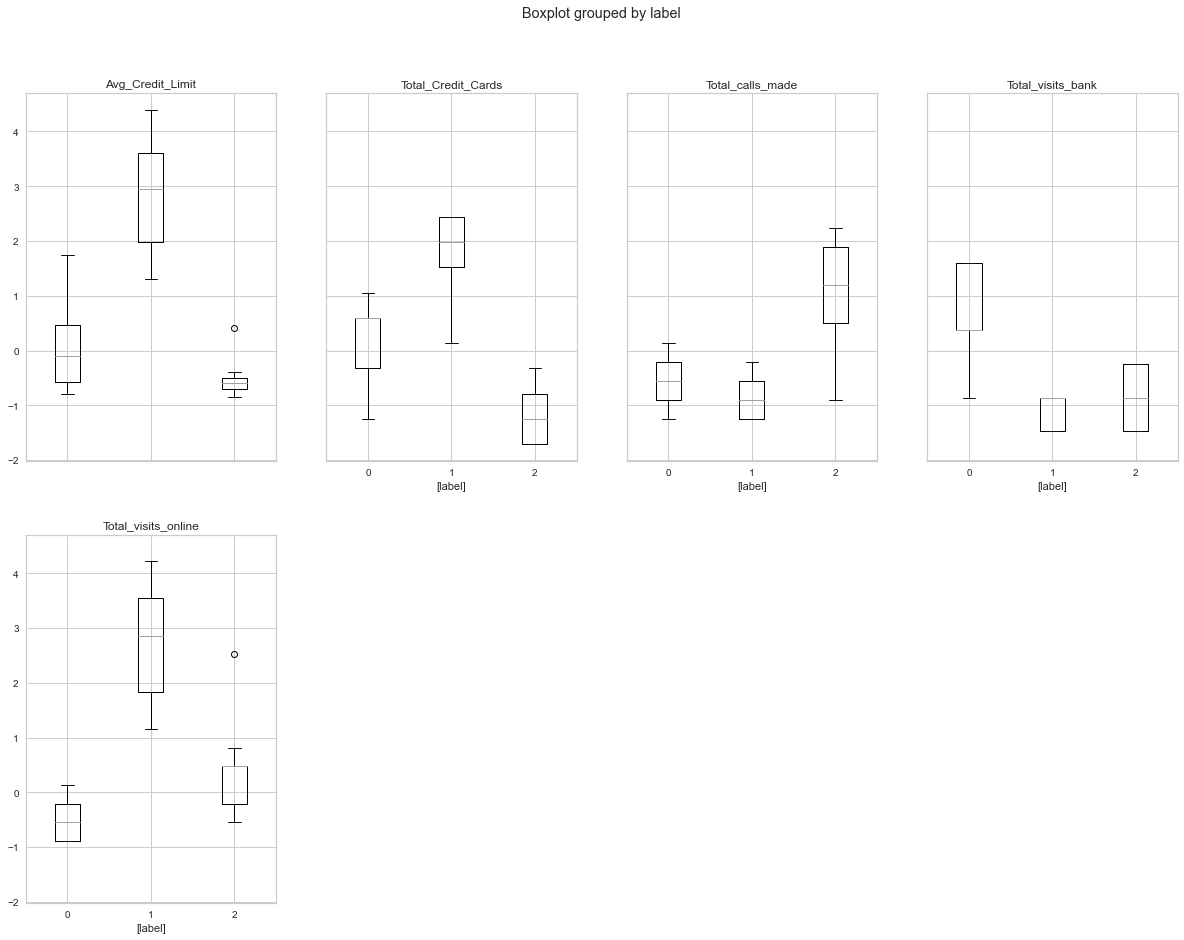

In [88]:
# Analyze the clusters using boxplot
creditz_clusters_kmeans.boxplot(by = 'label',  layout=(2,4), figsize=(20, 15))

<br/>

# 4. Hierarchical clustering

In [13]:
# Define a function to create Dendogram and print the cophenetic coefficient
def createDendogram(df, method):
    Z = linkage(df, metric='euclidean', method=method)
    c, coph_dists = cophenet(Z , pdist(df))
    print("Cophenetic coeff. using", method, "method = ", c)
    print()
    plt.figure(figsize=(10, 5))
    plt.title("Dendogram: Linkage Method = '{0}'".format(method))
    plt.xlabel('sample index')
    plt.ylabel('Distance')
    dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
    plt.tight_layout()

Cophenetic coeff. using average method =  0.8977080867389372



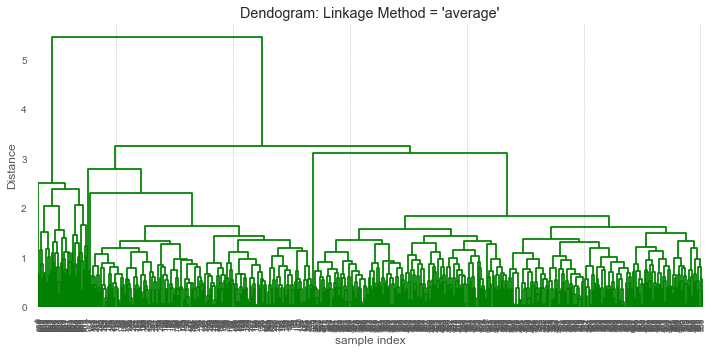

In [14]:
# Create Dendogram using average linkage method
createDendogram(credit_z, 'average')

Cophenetic coeff. using complete method =  0.8599730607972423



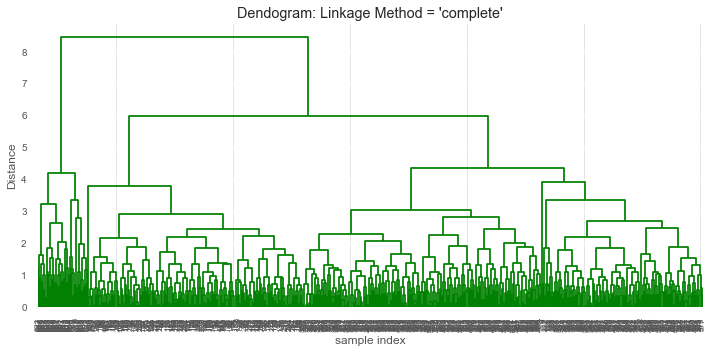

In [15]:
# Create Dendogram using complete linkage method
createDendogram(credit_z, 'complete')

Cophenetic coeff. using ward method =  0.7415156284827493



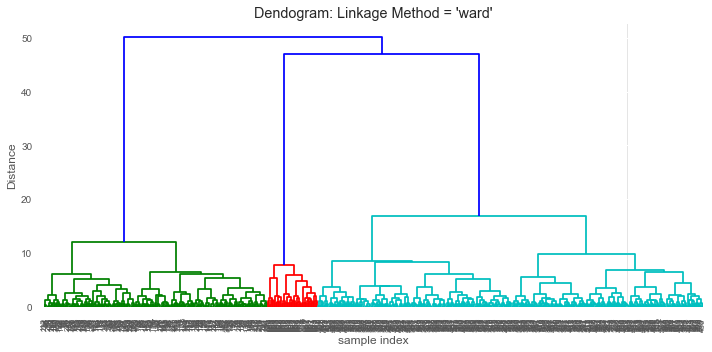

In [16]:
# Create Dendogram using ward linkage method
createDendogram(credit_z, 'ward')

<br/>

### Average linkage method gave the highest cophenetic coefficient
<br/>


In [98]:
# From the denodgram with the average linkage method,
# we can see 3 distinct clusters at a distance of 3
# We will run AgglomerativeClustering with cluster size as 3
cluster_hierarchical = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'average')
prediction_hierarchical = cluster_hierarchical.fit_predict(credit_z)

## create a new dataframe only for labels and converting it into categorical variable
df_labels = pd.DataFrame(prediction_hierarchical , columns = list(['label']))
df_labels['label'] = df_labels['label'].astype('category')

# Join the label dataframe with the data frame.
creditz_clusters_hierarchical = credit_z.join(df_labels)
creditz_clusters_hierarchical.head()

Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
0              1.74               -1.25              -0.86   
1              0.41               -0.79              -1.47   
2              0.41                1.06              -0.86   
3             -0.12                0.14              -0.86   
4              1.74                0.60              -1.47   

   Total_visits_online  Total_calls_made label  
0                -0.55             -1.25     0  
1                 2.52              1.89     2  
2                 0.13              0.15     0  
3                -0.55              0.15     0  
4                 3.20             -0.20     1

/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/kumarashok/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/kumaras

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1095fd710>,
      dtype=object)

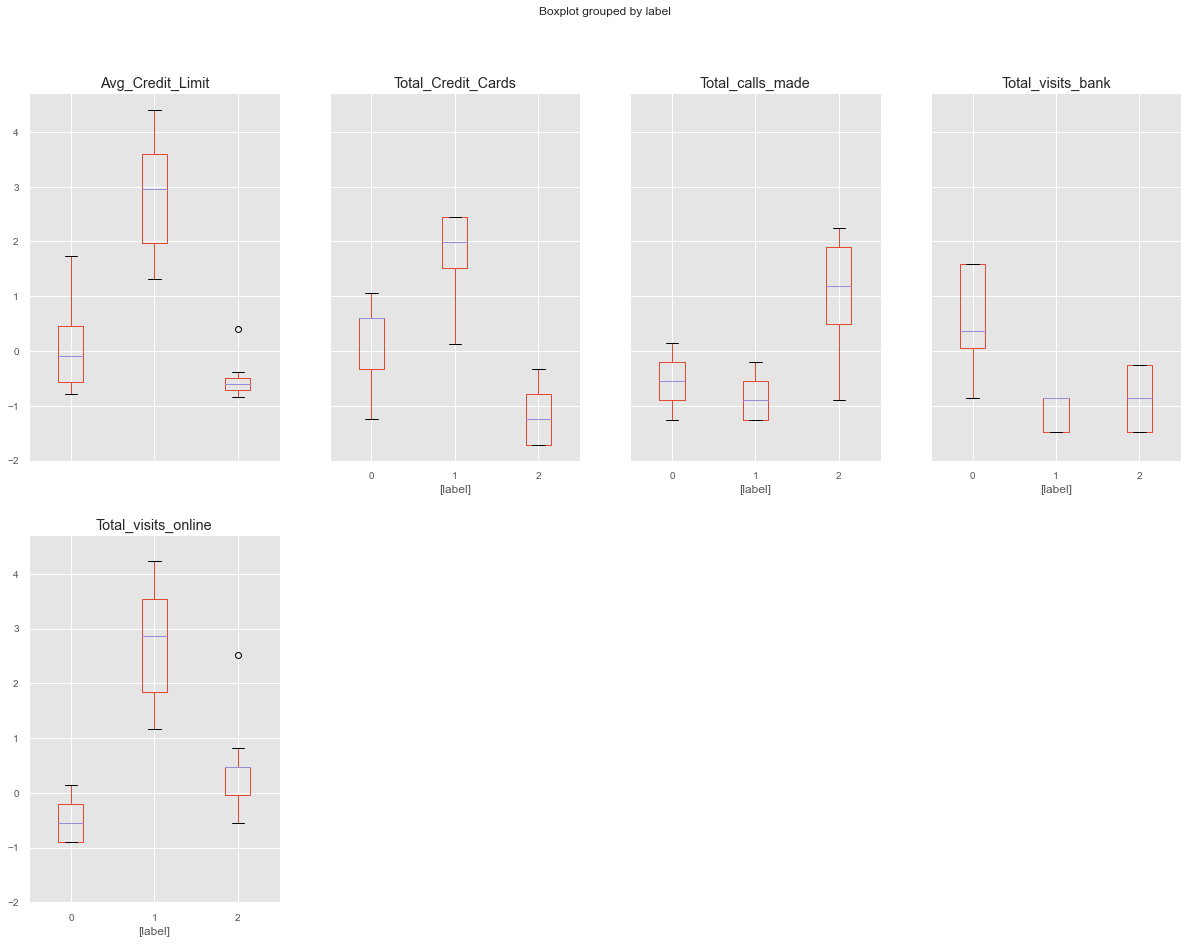

In [18]:
# Analyze the clusters using boxplot
creditz_clusters_hierarchical.boxplot(by = 'label',  layout=(2,4), figsize=(20, 15))

<br/>

# 5. Silhouette score

In [75]:
# Find average silhouette score for the K-Means clusters
silhouette_kmeans = silhouette_score(credit_z, prediction_kmeans)
print("Silhouette score for KMeans clusters = ", silhouette_kmeans)
      
# Find average silhouette score for the Hierarchical clusters
silhouette_hierarchical = silhouette_score(credit_z, prediction_hierarchical)
print("Silhouette score for Hierarchical clusters = ", silhouette_hierarchical)

Silhouette score for KMeans clusters =  0.5157182558881063
Silhouette score for Hierarchical clusters =  0.515922432650965


<br/>

### Silhouette score is slightly better for the Agglomertive Hierarchical clusters
<br/>


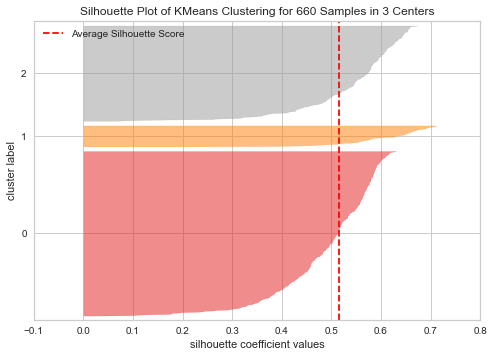

In [76]:
# Visualize the silhouette coefficient for the KMeans clusters
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(credit_z)    
visualizer.show();

<br/>

# 6. Compaison of K-Means and Hierarchical Clusters

In [99]:
# Statistical summary for the K-Means clusters
creditz_clusters_kmeans.groupby(['label']).describe()

Avg_Credit_Limit                                          \
                 count  mean  std   min   25%   50%   75%  max   
label                                                            
0               386.00 -0.02 0.59 -0.79 -0.57 -0.10  0.46 1.74   
1                50.00  2.83 0.92  1.31  1.97  2.95  3.60 4.40   
2               224.00 -0.60 0.14 -0.84 -0.71 -0.60 -0.49 0.41   

      Total_Credit_Cards                                           \
                   count  mean  std   min   25%   50%   75%   max   
label                                                               
0                 386.00  0.37 0.53 -1.25 -0.33  0.60  0.60  1.06   
1                  50.00  1.86 0.59  0.14  1.52  1.98  2.44  2.44   
2                 224.00 -1.06 0.51 -1.71 -1.71 -1.25 -0.79 -0.33   

      Total_visits_bank                                           \
                  count  mean  std   min   25%   50%   75%   max   
label                                                              
0                386.00  0.67 0.70 -0.86  0.37  0.37  1.59  1.59   
1                 50.00 -1.11 0.30 -1.47 -1.47 -0.86 -0.86 -0.86   
2                224.00 -0.90 0.49 -1.47 -1.47 -0.86 -0.25 -0.25   

      Total_visits_online                                          \
                    count  mean  std   min   25%   50%   75%  max   
label                                                               
0                  386.00 -0.55 0.29 -0.89 -0.89 -0.55 -0.21 0.13   
1                   50.00  2.83 0.98  1.16  1.84  2.86  3.54 4.22   
2                  224.00  0.32 0.42 -0.55 -0.21  0.48  0.48 2.52   

      Total_calls_made                                           
                 count  mean  std   min   25%   50%   75%   max  
label                                                            
0               386.00 -0.55 0.50 -1.25 -0.90 -0.55 -0.20  0.15  
1                50.00 -0.87 0.31 -1.25 -1.25 -0.90 -0.55 -0.20  
2               224.00  1.15 0.70 -0.90  0.49  1.19  1.89  2.24

In [101]:
# Statistical summary for the Hierarchical clusters
creditz_clusters_hierarchical.groupby(['label']).describe()

Avg_Credit_Limit                                          \
                 count  mean  std   min   25%   50%   75%  max   
label                                                            
0               387.00 -0.02 0.59 -0.79 -0.57 -0.10  0.46 1.74   
1                50.00  2.83 0.92  1.31  1.97  2.95  3.60 4.40   
2               223.00 -0.60 0.14 -0.84 -0.71 -0.60 -0.49 0.41   

      Total_Credit_Cards                                           \
                   count  mean  std   min   25%   50%   75%   max   
label                                                               
0                 387.00  0.37 0.53 -1.25 -0.33  0.60  0.60  1.06   
1                  50.00  1.86 0.59  0.14  1.52  1.98  2.44  2.44   
2                 223.00 -1.06 0.51 -1.71 -1.71 -1.25 -0.79 -0.33   

      Total_visits_bank                                           \
                  count  mean  std   min   25%   50%   75%   max   
label                                                              
0                387.00  0.66 0.70 -0.86  0.06  0.37  1.59  1.59   
1                 50.00 -1.11 0.30 -1.47 -1.47 -0.86 -0.86 -0.86   
2                223.00 -0.90 0.49 -1.47 -1.47 -0.86 -0.25 -0.25   

      Total_visits_online                                          \
                    count  mean  std   min   25%   50%   75%  max   
label                                                               
0                  387.00 -0.55 0.29 -0.89 -0.89 -0.55 -0.21 0.13   
1                   50.00  2.83 0.98  1.16  1.84  2.86  3.54 4.22   
2                  223.00  0.33 0.41 -0.55 -0.04  0.48  0.48 2.52   

      Total_calls_made                                           
                 count  mean  std   min   25%   50%   75%   max  
label                                                            
0               387.00 -0.55 0.50 -1.25 -0.90 -0.55 -0.20  0.15  
1                50.00 -0.87 0.31 -1.25 -1.25 -0.90 -0.55 -0.20  
2               223.00  1.15 0.69 -0.90  0.49  1.19  1.89  2.24

### Analysis
<br/>

From the box plots and the statistical summary of the two clustering methods, it's evident that both the clusters are very similar.
<br/>

Details:
> * All the clusters are equally well spearated in both the methods <br/>
> * The means of the various features within a cluster are almost the same between the two methods <br/>
> * The number of observations in each cluster betwen the two methods is almost the same <br/>
> * For cluster 1, both the methods have 50 observations each <br/>
> * However, for cluster 0 and 2, the counts differ by just 1 <br/>
> * Due to this the mean for Total_visits_bank for cluster 0 is slightly different between the methods <br/>
> * Due to this the mean for Total_visits_online for cluster 2 is slightly different between the methods <br/>

<br/>

# 7. Cluster Analysis
* Following are the characteristics of three clusters/segments of the customers:

<br/>

* Cluster 0: <br/>
> * These are customers with lower average_credit_limit and total_credit_cards
> * They make less number of calls and online visits to the bank, but make the most visits to the bank

<br/>

* Cluster 1: <br/>
> * These are customers with highest average_credit_limit and total_credit_cards
> * They make less calls and visits to the bank, but make the most online visits to the bank

<br/>

* Cluster 2: <br/>
> * These are customers with lowest average_credit_limit and total_credit_cards
> * They make less visits and online visits to the bank, but make the most calls to the bank


## Key Questions:
> 1. How many different segments of customers are there? <br/>
>> There are 3 distinct customer segments <br/>

> 2. How are these segments different from each other? <br/>
>> See the detailed analysis above <br/>

> 3. What are your recommendations to the bank on how to better market to and service these customers? <br/>
>> Cluster 0 and 2 customers make a lot of visits to the bank which means a higher turn around time for their service requests. <br/>
>> They can be targeted with campaigns to promote online visits which will result in lower turn around time and better satisfaction
<br/>
>> Cluster 2 customers could be the most dissatisifed customers as they have the least number of credit cards, but make the most calls to the bank. <br/>
>> This segment can be reached out to by the bank to address their issues to improve the satisfaction levels and then sell more credit cards to them. <br/>
<br/>
>> Cluster 1 customers have the highest average credit limit, number of credit cards and make the most use of bank's onine facility. <br/>
>> This group can be targeted to upsell bank's other financial products via online campaigns.
